In [ ]:
import gdown
import zipfile
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Extracción de los datos

Se recupera el conjunto de imágenes a procesar desde su origen. Los datos ya se encuentran divididos en una estructura de carpetas que permite constituir el set de entrenamiento y validación, con su correspondiente etiqueta.

In [ ]:
zip_file_url = 'https://drive.google.com/uc?id=1YsQ8qT69UKG3hqfO-Ab550PJobnVJApV'
zip_file_name = gdown.download(zip_file_url, quiet=True)

zip_folder_name = Path(zip_file_name).stem

zip_file_manager = zipfile.ZipFile(zip_file_name, 'r')
zip_file_manager.extractall()

Algunas constantes.

In [ ]:
TRAIN_IMAGES_FOLDER = f'{zip_folder_name}/training/'
VALID_IMAGES_FOLDER = f'{zip_folder_name}/validation/'
BATCH_SIZE = 32

El conjunto de **entrenamiento** se expande utilizando la técnica de aumento de imágenes.

In [ ]:
train_generator = ImageDataGenerator(rotation_range=90, brightness_range=[0.1, 0.7], width_shift_range=0.5, 
                                     height_shift_range=0.5, horizontal_flip=True, vertical_flip=True,
                                     preprocessing_function=preprocess_input)

valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
traingen = train_generator.flow_from_directory(TRAIN_IMAGES_FOLDER, target_size=(224, 224), class_mode='categorical',
                                               subset='training', batch_size=BATCH_SIZE, shuffle=True,
                                               seed=42)

validgen = valid_generator.flow_from_directory(VALID_IMAGES_FOLDER, target_size=(224, 224), class_mode='categorical',
                                             batch_size=1, shuffle=False, seed=42)

Found 201 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


Existen 201 instancias que serán transformadas, amplificando el valor que aportan al entrenamiento del modelo elegido. Las métricas de performance se calcularán sobre 52 imágenes, apartadas para tal fin y que no sufrirán ninguna alteración con objeto de corresponer el escenario de prueba con la implementación definitiva.

# Definición del modelo

El modelo elegido es una red convolucional preentrenada cuya arquitectura se conoce como VGG16 debido a sus 16 capas con pesos.

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compila un modelo integrado a las capas pre entrenadas de VGG16
    
    input_shape: tupla - shape de las imágenes input (width, height, channels)
    n_classes: entero - número de clases en la capa output
    optimizer: string - optimizador usado para entrenar. Por defecto en rmsprop
    fine_tune: entero - número de capas preentrenadas que vamos a desfrezear. 
                Si lo seteamos en 0, todas las capas preentrenadas serán freezeadas.
    """
    
    # Cargamos las capas de la CNN con los pesos preentrenados con Imagenet
    # include_top=False es para excluir la parte fully connected de la red
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Definimos cuántas capas vamos a freezear en el entrenamiento
    # Las capas en la base convolucional se switchean de entrenable a no entrenable
    # según el número fine_tune
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Creamos un nuevo "top" model (fully connected)
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1028, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Juntamos modelo convolucional con fully connected en un objeto Model
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compilamos
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

Para adaptar la solución al dominio específico, se suman tres capas a la convolución a entrenar con las imágenes específicas del problema.

# Entrenamiento

En la mayoría de las redes convolucionales, cuanto más arriba está una capa, más especializada es. Las primeras aprenden características muy simples que se generalizan a casi todos los tipos de imágenes. A medida que avanza, las funciones son cada vez más propias para el conjunto de datos en el que se entrenó el modelo. 

El objetivo del *fine tuning* es adaptar estas características para que funcionen con el nuevo set, en lugar de sobrescribir el aprendizaje genérico.

Por lo descripto, se decide reentrenar los pesos obtenidos de las últimas capas. Iniciando con los parámetros originales e ir incorporando, de a una, las tres últimas; con intención de determinar cuál es la configuración que mejor performa.


In [ ]:
INPUT_SHAPE = (224, 224, 3)
CLASSES = 2
EPOCHS = 50
MAX_TRAINABLE_LAYERS = 4

Se itera, entrenando en cada bucle una red a la cual se incorpora una capa final en cada ejecución del bloque subordinado.

In [ ]:
history = {}
accuracy = {}

n_steps = (traingen.samples//BATCH_SIZE) + 1
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min')

for trainable_layer in range(MAX_TRAINABLE_LAYERS):
  
  optimizer = Adam(learning_rate=0.001) if trainable_layer == 0 else Adam(learning_rate=0.0001)
  
  tl_checkpoint = ModelCheckpoint(filepath=f'{trainable_layer}.weights.best.hdf5',
                                  save_best_only=True, verbose=False)
  
  # creación del modelo incorporando al entrenamiento n (trainable_layer) capas de la arquitectura original + MLP 
  vgg_model = create_model(INPUT_SHAPE, CLASSES, optimizer, fine_tune=trainable_layer)
  
  # entrenamiento
  history[trainable_layer] = vgg_model.fit(traingen, batch_size=BATCH_SIZE, epochs=EPOCHS,
                              steps_per_epoch=n_steps, validation_data=validgen,
                              callbacks=[early_stop, tl_checkpoint], verbose=False)
  
  # predicción y cálculo de la métrica
  vgg_model.load_weights(f'{trainable_layer}.weights.best.hdf5')
  vgg_predict_proba = vgg_model.predict(validgen)
  vgg_predict_classes = np.argmax(vgg_predict_proba, axis=1)

  accuracy[trainable_layer] = accuracy_score(validgen.classes, vgg_predict_classes)

58900480/58889256 [==============================] - 0s 0us/step


# Resultados

Se evaluan los resultados, tanto la evolución (en cada época) de la exactitud como el error obtenido. 

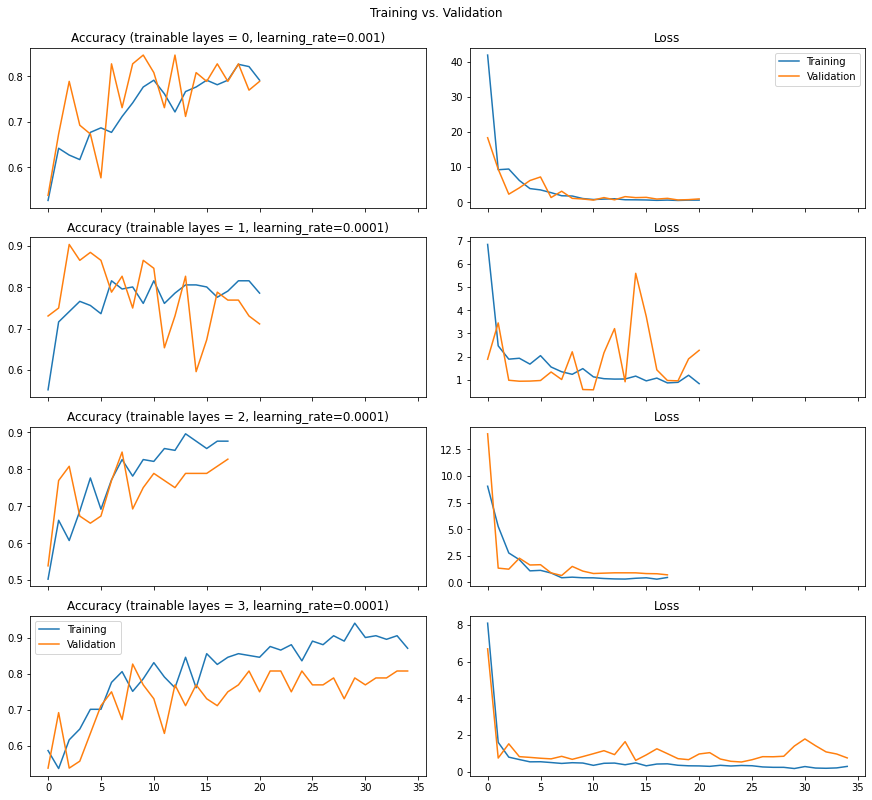

In [ ]:
fig, axs = plt.subplots(MAX_TRAINABLE_LAYERS, 2, figsize=(12,11), sharex=True,
                        constrained_layout=True)

fig.suptitle('Training vs. Validation')

for i in range(MAX_TRAINABLE_LAYERS):
  acc = history[i].history['accuracy']
  val_acc = history[i].history['val_accuracy']

  loss = history[i].history['loss']
  val_loss = history[i].history['val_loss']

  axs[i][0].plot(acc, label='Training')
  axs[i][0].plot(val_acc, label='Validation')
  
  axs[i][1].plot(loss, label='Training')
  axs[i][1].plot(val_loss, label='Validation')
  
  axs[i][0].set_title(f'Accuracy (trainable layes = {i}, learning_rate={0.001 if i == 0 else 0.0001})')
  axs[i][1].set_title(f'Loss')

  if i == MAX_TRAINABLE_LAYERS-1:
    axs[i][0].legend(loc='best')

  if i == 0:    
    axs[i][1].legend(loc='best')

plt.show()

Se muestran conjuntamente la performance del mejor modelo obtenido en cada configuración propuesta.

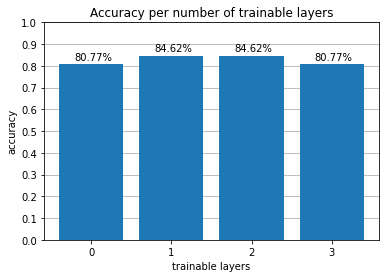

In [ ]:
plt.title('Accuracy per number of trainable layers')
plt.grid(axis = 'y', zorder=0)
plt.bar(*zip(*accuracy.items()), zorder=3)
plt.xlabel('trainable layers')
plt.ylabel('accuracy')
plt.xticks([*accuracy])
plt.yticks(np.arange(0.0, 1.1, 0.1))

for index, value in enumerate([*accuracy.values()]):
    plt.text(index-0.21, value + 0.02, f'{value:.2%}')

plt.show()

Lo expuesto presenta al modelo que reentrena las dos últimas capas de la red (más el perceptron multicapas agregado) como el de mejor comportamiento, tanto en su métrica final como en la evolución del error. No hay evidencia de sobre ajuste.

# Anexo

Debido al hecho que la red se obtiene pre entrenada y solo se calculan los pesos de la capas incorporadas, hacerla parte de cada época de entrenamiento es inútil, siempre se obtiene el mismo resultado.

Por esto, se realiza una predicción sobre los datos originales, y el resultado se convierte en el nuevo set de entrenamiento/validación. Ahora solo se deben optimizar los pesos de la sección personalida de la arquitectura.

## Extracción

In [ ]:
# se obtienen las imágenes transformadas
data = traingen.next()
X_train = data[0]
y_train = data[1]

for i in range(traingen.n - 1):
  data = traingen.next()
  X_train = np.concatenate((X_train, data[0]), axis=0)
  y_train = np.concatenate((y_train, data[1]), axis=0)

In [ ]:
# se optienen las imágenes de prueba
data = validgen.next()
X_test = data[0]
y_test = data[1]

for i in range(validgen.n - 1):
  data = validgen.next()
  X_test = np.concatenate((X_test, data[0]), axis=0)
  y_test = np.concatenate((y_test, data[1]), axis=0)

## Modelo base

In [ ]:
# se crea el modelo
conv_base = VGG16(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

## Predicciones

In [ ]:
# se calculan las predicciones sobre los datos originales para constituirlos en el nuevo set de entrenamiento/valudación
train_pred = conv_base.predict(X_train)
valid_pred = conv_base.predict(X_test)

## Modelo propio del dominio

In [ ]:
#MLP
top_model = Sequential()
top_model.add(Flatten(name="flatten", input_shape=train_pred.shape[1:]))
top_model.add(Dense(4096, activation='relu'))
top_model.add(Dense(1028, activation='relu'))
top_model.add(Dropout(0.2))
top_model.add(Dense(CLASSES, activation='softmax'))
 
optimizer = Adam(learning_rate=0.001)

top_model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                  metrics=['accuracy'])

## Entrenamiento

In [ ]:
n_steps = (train_pred.shape[0]//BATCH_SIZE) + 1
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min')
tl_checkpoint = ModelCheckpoint(filepath='weights.best.hdf5',
                                  save_best_only=True, verbose=False)

In [ ]:
history = top_model.fit(x=train_pred, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                              steps_per_epoch=n_steps, validation_data=(valid_pred, y_test),
                              callbacks=[early_stop, tl_checkpoint], verbose=False)

## Validación

In [ ]:
top_model.load_weights('weights.best.hdf5')
vgg_predict_proba = top_model.predict(valid_pred)
vgg_predict_classes = np.argmax(vgg_predict_proba, axis=1)

In [ ]:
acc_only_top_model = accuracy_score(validgen.classes, vgg_predict_classes)

In [ ]:
print(f'Accuracy: {acc_only_top_model:.2%}')

Accuracy: 80.77%


Esto tiene sentido cuando la red se utiliza con sus parámetros originales. Por esto se compara el resultado con la primera propuesta de la sección **Entrenamiento**.